In [116]:
import yfinance as yf
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [ ]:
#Fetching
def fetch_ticker_data(
        tickers: list[str] = None, 
        start_date: str = '2020-01-01', 
        end_date: str = '2025-01-01', 
        interval: str = '1d',
        group_by: str = 'ticker',
) -> pd.DataFrame:
    output = []
    for tick in tickers:
        try:
            data = yf.download(
                tickers=tick, 
                start=start_date, 
                end=end_date, 
                interval=interval, 
                group_by=group_by
            )
            data.reset_index(inplace=True)
            if isinstance(data.columns, pd.MultiIndex):
                data.columns = [
                    col[1] if col[0] != 'Date' else col[0] for col in data.columns]
            data['Ticker'] = tick 
            output.append(data)
            print(f"Data fetched successfully for {tick}.")
        except Exception as e:
            print(f"Error fetching data for ticker {tick}: {e}")
            continue 
    output_df = pd.concat(output, ignore_index=True)
    return output_df

tickers = ["AAPL"] 
data = fetch_ticker_data(tickers)

[*********************100%***********************]  1 of 1 completed

Data fetched successfully for AAPL.


In [118]:
def schema_data(data: pd.DataFrame) -> None:
    if isinstance(data, pd.DataFrame):
        print("########### Schema ###########")
        print(data.shape)
        print(data.dtypes)
    else:
        raise TypeError(f"Input must be a DataFrame, instead got {type(data)}")
schema_data(data)

########### Schema ###########
(1258, 7)
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Ticker            object
dtype: object


In [119]:
def handle_date_column(data: pd.DataFrame, date_column: str = 'Date') -> pd.DataFrame:
    if isinstance(data, pd.DataFrame):
        if date_column not in data.columns:
            raise KeyError(f"Column '{date_column}' not found in the DataFrame. Available columns: {data.columns.tolist()}")
        data[date_column] = pd.to_datetime(data[date_column])
        data.set_index(date_column, inplace=True)
        print(f"Date column '{date_column}' successfully converted and set as index.")
        return data
    else:
        raise TypeError(f"Input must be a DataFrame, instead got {type(data)}")

data = handle_date_column(data)

Date column 'Date' successfully converted and set as index.


In [120]:
def describe_data(data: pd.DataFrame) -> pd.DataFrame:
    if isinstance(data, pd.DataFrame):
        print("########### Summary Statistics ###########")
        print(data.describe())
    else:
        raise TypeError(f"Input must be dataframe, instead got {type(data)}")
describe_data(data)

########### Summary Statistics ###########
              Open         High          Low        Close        Volume
count  1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03
mean    152.022500   153.707452   150.471750   152.177631  9.057384e+07
std      42.016644    42.214240    41.849262    42.073135  5.325460e+07
min      55.350223    55.452148    51.595979    54.449883  2.323470e+07
25%     126.388682   128.070228   124.935171   126.946356  5.546825e+07
50%     150.580333   152.511339   148.819366   150.760994  7.627980e+07
75%     176.636637   178.390045   175.258402   176.831432  1.077425e+08
max     257.906429   259.814335   257.347047   258.735504  4.265100e+08


In [121]:
def log_transform(data: pd.DataFrame, ticker: str, column: str) -> pd.DataFrame:
    if isinstance(data, pd.DataFrame):
        if ticker not in data['Ticker'].unique():
            raise ValueError(f"Ticker '{ticker}' not found in the column. Available tickers: {data['Ticker'].unique().tolist()}")
        ticker_data = data[data['Ticker'] == ticker]
        if column not in ticker_data.columns:
            raise KeyError(f"Column '{column}' not found in the dataFrame. Available columns: {ticker_data.columns.tolist()}")
        
        ticker_data[f'Log_{column}'] = np.log(ticker_data[column])
        print(f"Log transformed {column} for {ticker}.")
        return ticker_data
    else:
        raise TypeError(f"Input must be a dataFrame, instead got {type(data)}")


transformed_data = []
columns_to_transform = ["Close"]
for tick in tickers:
    for col in columns_to_transform:
        ticker_transformed = log_transform(data, tick, col)
        transformed_data.append(ticker_transformed)
transformed_data = pd.concat(transformed_data, ignore_index=True)

Log transformed Close for AAPL.


########### Plot ###########


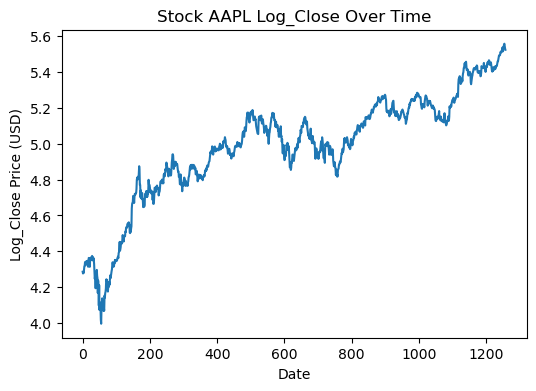

In [122]:
#y_t = log p_t(column=Log_Close)
#[plot]
def plot_serie(data: pd.DataFrame, ticker: str, column: str) -> None:
    if isinstance(data, pd.DataFrame):
        if ticker not in data['Ticker'].unique():
            raise ValueError(f"Ticker '{ticker}' not found in the 'Ticker' column. Available tickers: {data['Ticker'].unique().tolist()}")
        ticker_data = data[data['Ticker'] == ticker]
        if column not in ticker_data.columns:
            raise KeyError(f"Column '{column}' not found in the DataFrame. Available columns: {ticker_data.columns.tolist()}")
        print("########### Plot ###########")
        ticker_data[column].plot(title=f"Stock {ticker} {column} Over Time", figsize=(6, 4))
        plt.xlabel("Date")
        plt.ylabel(f"{column} Price (USD)")
        plt.show()
    else:
        raise TypeError(f"Input must be a DataFrame, instead got {type(data)}")
plot_serie(data= transformed_data, ticker = tickers[0], column = 'Log_Close')

Log returns for 'Log_Close' successfully calculated and added to DataFrame.
########### Plot ###########


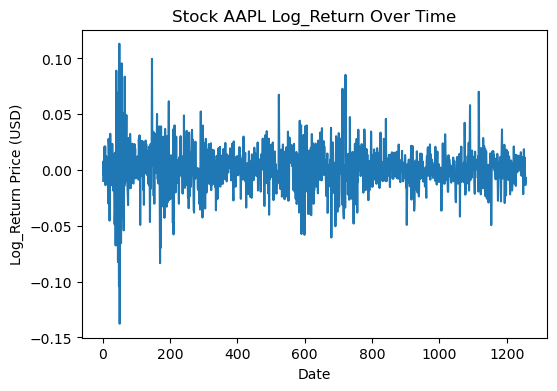

In [123]:
#r_t = y_t - y_t-1 
#[plot]
def calculate_log_returns(data: pd.DataFrame, column: str = 'Log_Close') -> pd.DataFrame:
    if isinstance(data, pd.DataFrame):
        if column not in data.columns:
            raise KeyError(f"Column '{column}' not found in the DataFrame. Available columns: {data.columns.tolist()}")
        
        data['Log_Return'] = data[column].diff()
        print(f"Log returns for '{column}' successfully calculated and added to DataFrame.")
        return data
    else:
        raise TypeError(f"Input must be a DataFrame, instead got {type(data)}")

transformed_data = calculate_log_returns(transformed_data)
plot_serie(data= transformed_data, ticker = tickers[0], column = 'Log_Return')

########### Distribution of Log_Return ###########


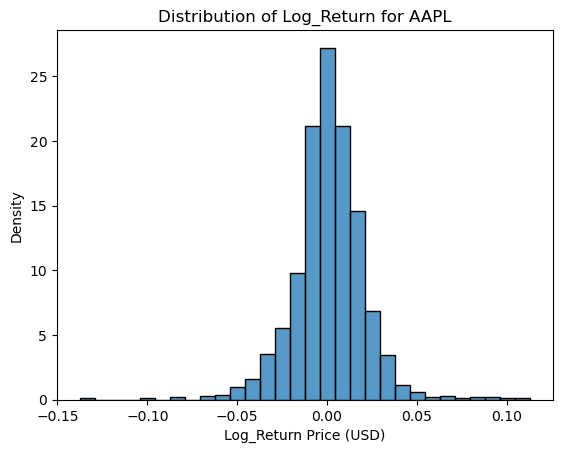

In [130]:
    
def plot_distribution(data: pd.DataFrame, ticker: str, column: str, kde: bool = False) -> None:
    if isinstance(data, pd.DataFrame):
        if ticker not in data['Ticker'].unique():
            raise ValueError(f"Ticker '{ticker}' not found in the 'Ticker' column. Available tickers: {data['Ticker'].unique().tolist()}")
        ticker_data = data[data['Ticker'] == ticker]
        if column not in ticker_data.columns:
            raise KeyError(f"Column '{column}' not found in the DataFrame. Available columns: {ticker_data.columns.tolist()}")
        
        print(f"########### Distribution of {column} ###########")
        sns.histplot(ticker_data[column], kde=kde, bins=30, stat="density")
        plt.title(f"Distribution of {column} for {ticker}")
        plt.xlabel(f"{column} Price (USD)")
        plt.ylabel("Density")
        plt.show()
    else:
        raise TypeError(f"Input must be a DataFrame, instead got {type(data)}")
plot_distribution(data= transformed_data, ticker = tickers[0], column = 'Log_Return')

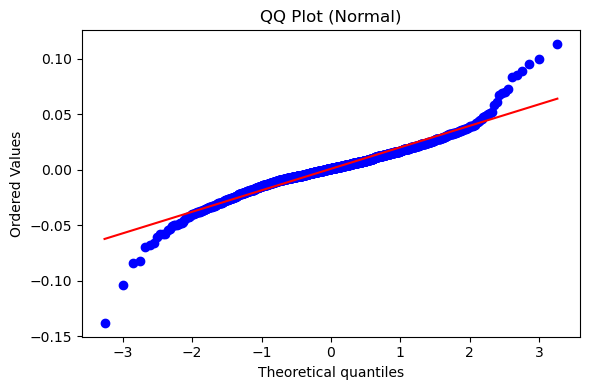

In [131]:
def plot_qq_comparison(data: pd.DataFrame, column: str = 'Log_Return', dist_type: str = 'norm') -> None:
    if isinstance(data, pd.DataFrame):
        if column not in data.columns:
            raise KeyError(f"Column '{column}' not found in the DataFrame. Available columns: {data.columns.tolist()}")
        
        sample_data = data[column].dropna()

        plt.figure(figsize=(6, 4))

        try:
            if dist_type == 'norm':
                stats.probplot(sample_data, dist="norm", plot=plt)
                plt.title(f"QQ Plot (Normal)")
            else:
                raise ValueError(f"Invalid distribution type '{dist_type}'. Choose from ['norm']")            
            plt.tight_layout()
            plt.show()
        except Exception as e:
            raise ValueError(f"Error plotting QQ plot for distribution '{dist_type}': {e}")
    else:
        raise TypeError(f"Input must be a DataFrame, instead got {type(data)}")

plot_qq_comparison(transformed_data, column='Log_Return', dist_type='norm')  


In [132]:
def test_normality(data: pd.DataFrame, column: str = 'Log_Return', test_type: str = 'anderson') -> None:
    if isinstance(data, pd.DataFrame):
        if column not in data.columns:
            raise KeyError(f"Column '{column}' not found in the DataFrame. Available columns: {data.columns.tolist()}")
        sample_data = data[column].dropna()
        try:
            if test_type == 'anderson':
                result = stats.anderson(sample_data, dist='norm')  
                print(f"Anderson-Darling Test Result: Test Statistic = {result.statistic:.4f}, Critical Value = {result.critical_values[2]:.4f}.")
            else:
                raise ValueError(f"Invalid test type '{test_type}'. Choose from ['anderson']")
        except Exception as e:
            raise ValueError(f"Error performing normality test '{test_type}': {e}")
    else:
        raise TypeError(f"Input must be a DataFrame, instead got {type(data)}")

test_normality(transformed_data, column='Log_Return')


Anderson-Darling Test Result: Test Statistic = 12.2555, Critical Value = 0.7850.


#Project Planning1
DEADLINE: MARCH

#Chapter1: Stylized Facts
1) Stylized Facts (SF) (p.20)
eg. non-stationarity (past returns don't reflect necessarly future returns)

2) Price/Return
logarithmic price/return
random walk 
+plots

3) Distr.
emperical distr.
non-gaussian distr. (incl. sf wrt. distr.)
+plots

4) Temporal Price/Return Structure
idd (incl. sf wrt. volatillity clustering)


#Chapter2: iid modeling (incl. RECAP; econometrics)

1) Model
random walk
estimation (incl. gaussian/non-gaussian)
#+plots

2) (Statistical) Factor Model
estimation
#+plots

3) PCA

#Chapter3: serie modeling (incl. RECAP; econometrics)

1) Model
ARMA
Volatiliy Modeling (eg. GARCH)

#Chapter4; graphs

#Project Planning2
DEADLINE: APRIL
#Chapter4: Portfolio
